In [1]:
frame_index = 0  # 设置想解析的帧的序号

# 解析LVDS接收的ADC原始IQ数据

## 利用numpy对LVDS接收的ADC原始IQ数据进行解析

### 载入相关库

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 设置对应参数

In [3]:
# 可根据cfg文件自己填写（运行采集程序时终端也会打印）
# ADC_PARAMS={'chirps': 64, 'rx': 4, 'tx': 2, 'samples': 256, 'IQ': 2, 'bytes': 2, 'freq_slope': 100, 'sample_rate': 12221}

# 也可从cfg文件自动读取参数
from mmwave.dataloader import DCA1000
_,_,ADC_PARAMS,_=DCA1000.read_config("xwr18xx_profile.cfg")
print(ADC_PARAMS)

###以下参数不用改
# STATIC
MAX_PACKET_SIZE = 4096
BYTES_IN_PACKET = 1456  # Data in payload per packet from FPGA
BYTES_OF_PACKET = 1466  # payload size per packet from FPGA
MAX_BYTES_PER_PACKET = 1470  # Maximum bytes in the data packet
FPGA_CLK_CONVERSION_FACTOR = 1000  # Record packet delay clock conversion factor
FPGA_CLK_PERIOD_IN_NANO_SEC = 8  # Record packet delay clock period in ns
VERSION_BITS_DECODE = 0x7F  # Version bits decode
VERSION_NUM_OF_BITS = 7  # Number of bits required for version
PLAYBACK_BIT_DECODE = 0x4000  # Playback FPGA bitfile identifier bit
# DYNAMIC
BYTES_IN_FRAME = (ADC_PARAMS['chirps'] * ADC_PARAMS['rx'] * ADC_PARAMS['tx'] *
                  ADC_PARAMS['IQ'] * ADC_PARAMS['samples'] * ADC_PARAMS['bytes'])
BYTES_IN_FRAME_CLIPPED = (BYTES_IN_FRAME // BYTES_IN_PACKET) * BYTES_IN_PACKET
PACKETS_IN_FRAME = BYTES_IN_FRAME / BYTES_IN_PACKET
PACKETS_IN_FRAME_CLIPPED = BYTES_IN_FRAME // BYTES_IN_PACKET
UINT16_IN_PACKET = BYTES_IN_PACKET // 2
UINT16_IN_FRAME = BYTES_IN_FRAME // 2

{'startFreq': 77, 'idleTime': 25.0, 'rampEndTime': 48.96, 'adc_valid_start_time': 7.0, 'frame_periodicity': 10.0, 'chirps': 64, 'rx': 4, 'tx': 2, 'samples': 256, 'IQ': 2, 'bytes': 2, 'freq_slope': 81.699, 'sample_rate': 12500}


### 载入保存的bin数据并解析

In [4]:
adc_data = np.fromfile("raw_data_2022-07-29-00-47-44.bin", dtype=np.int16)

adc_data=np.reshape(adc_data,(-1,ADC_PARAMS['chirps'],ADC_PARAMS['tx'],ADC_PARAMS['rx'],ADC_PARAMS['samples']//2,ADC_PARAMS['IQ'],2))
#100Frames*16Chirps*2TX*4RX*32(Samples//2)*2IQ(Lanes)*2Samples
print(adc_data.shape)

adc_data=np.transpose(adc_data,(0,1,2,3,4,6,5))
adc_data=np.reshape(adc_data,(-1,ADC_PARAMS['chirps'],ADC_PARAMS['tx'],ADC_PARAMS['rx'],ADC_PARAMS['samples'],ADC_PARAMS['IQ']))
#100Frames*16Chirps*2TX*4RX*64Samples*2IQ(Lanes)
print(adc_data.shape)

adc_data = (1j * adc_data[:,:,:,:,:,0] + adc_data[:,:,:,:,:,1]).astype(np.complex64)
#100Frames*16Chirps*2TX*4RX*64Samples复数形式
print(adc_data.shape)

adc_data_2d = np.reshape(adc_data[:,:,0:2,:,:],(-1,ADC_PARAMS['chirps'],2*4,ADC_PARAMS['samples']))
#100Frames*16Chirps*8VirtualAnts*64Samples复数形式
print(adc_data_2d.shape)

(300, 64, 2, 4, 128, 2, 2)
(300, 64, 2, 4, 256, 2)
(300, 64, 2, 4, 256)
(300, 64, 8, 256)


### 绘制时域IQ波形

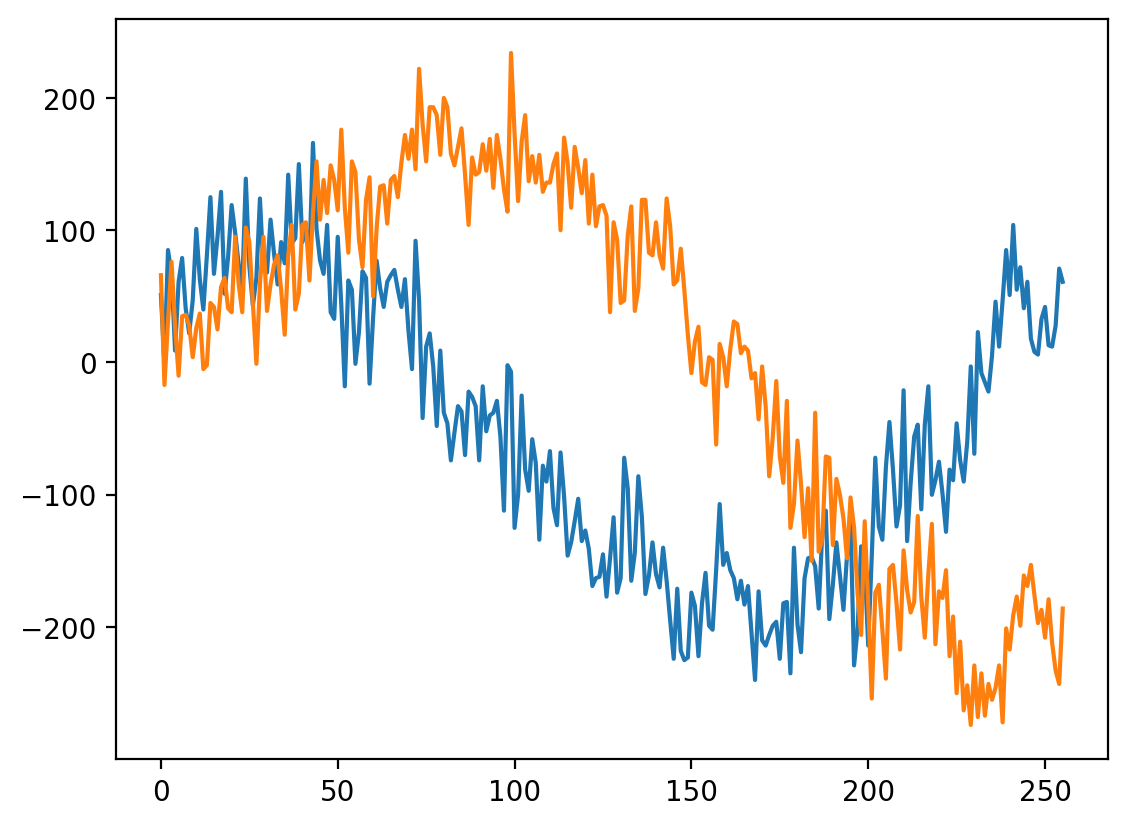

In [5]:
plt.plot(np.real(adc_data[frame_index,0,0,0,:])) # I路
plt.plot(np.imag(adc_data[frame_index,0,0,0,:])) # Q路
plt.show()

### 计算Range-FFT

Range Resolution: 0.08964881761098667 [meters]


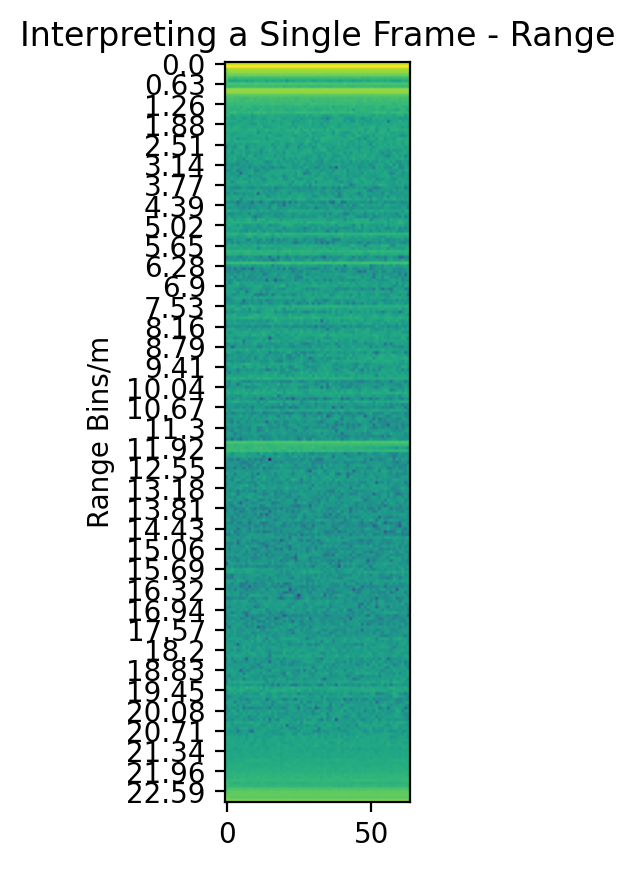

In [6]:
range_plot = np.fft.fft(adc_data_2d[frame_index], axis=2)
# Calculating bandwidth of the chirp, accounting for unit conversion
chirp_bandwidth = (ADC_PARAMS['freq_slope'] * 1e12 * ADC_PARAMS['samples']) / (ADC_PARAMS['sample_rate'] * 1e3)

# Using our derived equation for range resolution
range_res = 3e8 / (2 * chirp_bandwidth)
print(f'Range Resolution: {range_res} [meters]')

# Apply the range resolution factor to the range indices
ranges = np.round(np.arange(ADC_PARAMS['samples']) * range_res,2)

# Visualize Results
plt.imshow(np.log(np.abs(range_plot.sum(1)).T))
plt.ylabel('Range Bins/m')
plt.yticks(np.arange(ADC_PARAMS['samples'])[::7],ranges[::7])
plt.title('Interpreting a Single Frame - Range')
plt.show()

### 计算Doppler-FFT

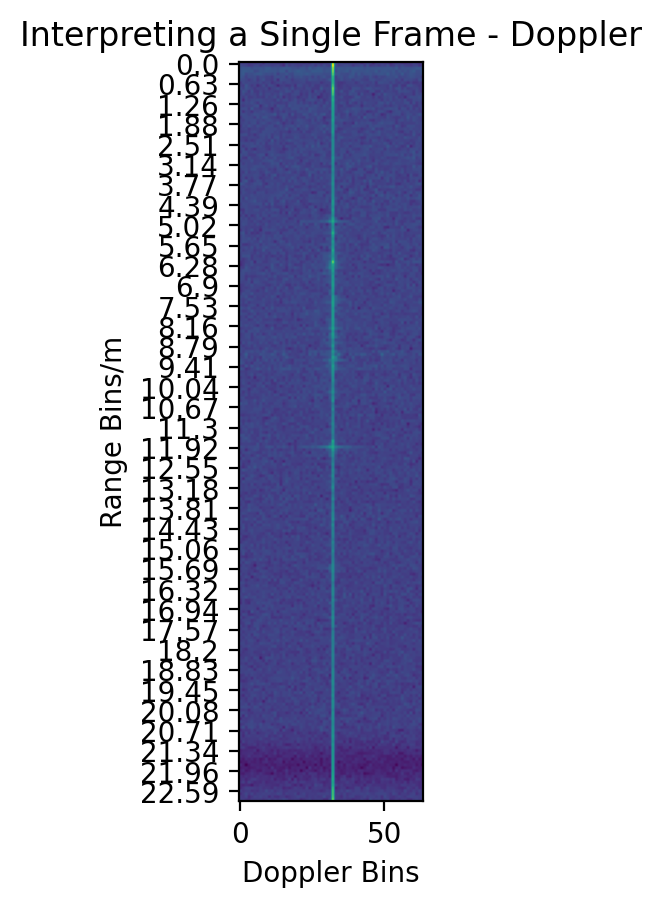

In [7]:
range_doppler = np.fft.fft(range_plot, axis=0)
range_doppler = np.fft.fftshift(range_doppler, axes=0)

# Visualize Results
plt.imshow(np.log(np.abs(range_doppler).T).sum(1))
plt.xlabel('Doppler Bins')
plt.ylabel('Range Bins/m')
plt.yticks(np.arange(ADC_PARAMS['samples'])[::7],ranges[::7])
plt.title('Interpreting a Single Frame - Doppler')
plt.show()

### 计算Azimuth-FFT

In [8]:
#将矩形图像转为环形
def fanScan(im,r0=0,angle=180,k=7,top=True):
    """将矩形图像转为环形
    im          - 输入二维图像
    angle       - 环形夹角度数
    r0          - 环形内圆半径，r0=0输出扇形
    k           - 临近点插值密度（如果图像上出现白噪点，可适当增加k值）
    top         - 环心在上部
    """
    h, w = im.shape # 输入图像的高度、宽度和通道数

    if r0 > 0: # 输出环形的话，图像上部增加背景
        bg = np.zeros((r0, w))
        im = np.append(bg, im, axis=0) if top else np.append(im, bg, axis=0)

    h, w = im.shape # 加上背景后图像的高度、宽度
    r = 2*h-1  # 输出图像高度和宽度
    im_fan = np.zeros((r, r)) # 生成输出图像的numpy数组

    idx = np.arange(h) if top else np.arange(h)[::-1]
    alpha = np.radians(np.linspace(-angle/2, angle/2, k*w)) # 生成扇形角度序列
    for i in range(k*w): # 遍历输入图像的每一列
        rows = np.int32(np.ceil(np.cos(alpha[i])*idx)) + r//2
        cols = np.int32(np.ceil(np.sin(alpha[i])*idx)) + r//2
        im_fan[(rows, cols)] = im[:,i//k]

    if 360 > angle >= 180: # 裁切输出图像上部的空白区域
        im_fan = im_fan[int(h*(1-np.sin(np.radians((angle/2-90))))):]

    if not top:
        im_fan = im_fan[::-1]
    return im_fan

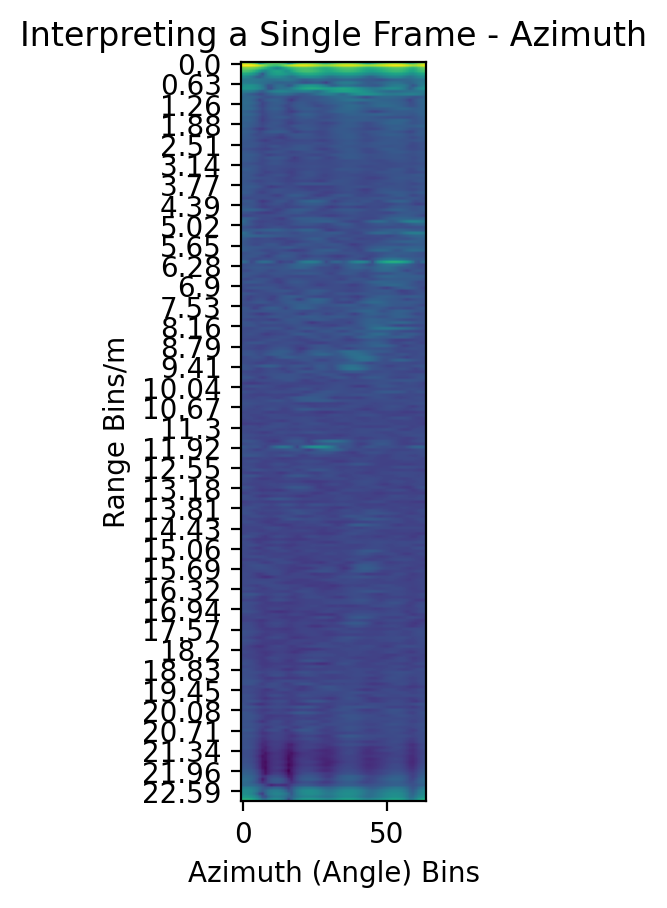

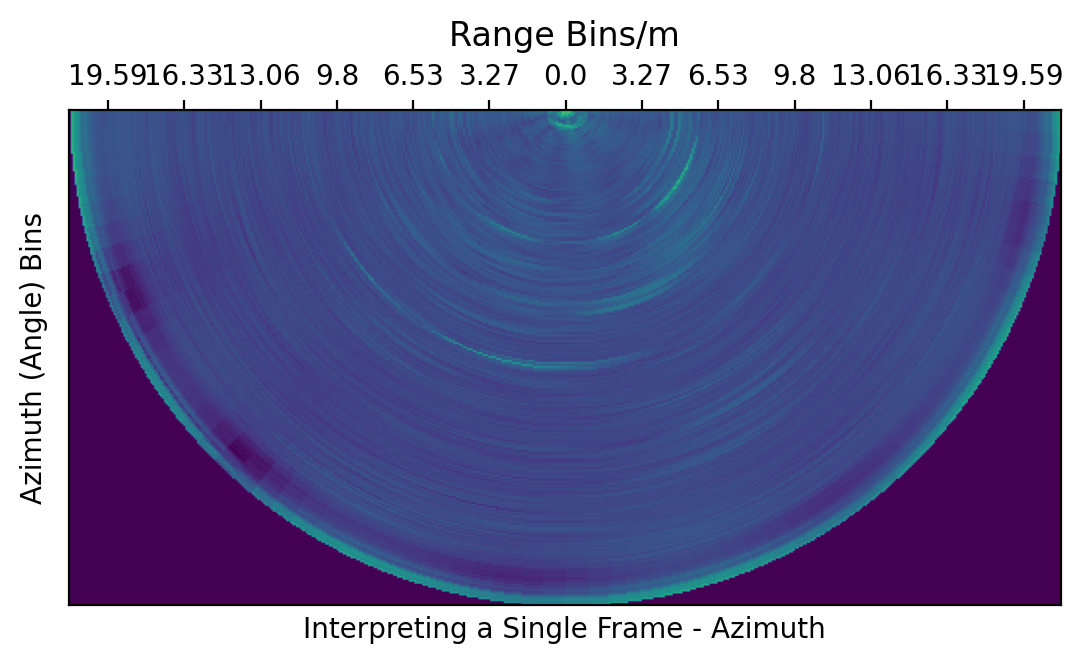

In [9]:
num_angle_bins = 64
padding = ((0,0), (0,num_angle_bins-range_doppler.shape[1]), (0,0))
range_azimuth = np.pad(range_doppler, padding, mode='constant')
range_azimuth = np.fft.fft(range_azimuth, axis=1)
range_azimuth = np.fft.fftshift(range_azimuth, axes=1)
range_azimuth = range_azimuth
# 绘制平面图
range_azimuth_img=np.log(np.abs(range_azimuth).sum(0).T)
range_azimuth_img=range_azimuth_img-np.min(range_azimuth_img)
range_azimuth_img=range_azimuth_img/np.max(range_azimuth_img)
plt.imshow(range_azimuth_img)
plt.xlabel('Azimuth (Angle) Bins')
plt.ylabel('Range Bins/m')
plt.yticks(np.arange(ADC_PARAMS['samples'])[::7],ranges[::7])
plt.title('Interpreting a Single Frame - Azimuth')
plt.show()

#绘制扇扫图
im_fan=fanScan(range_azimuth_img,r0=0,angle=180,k=50,top=True)
plt.imshow(im_fan)

#坐标标签上移
ax = plt.gca()
ax.xaxis.set_ticks_position('top')

#标注距离
lableNum=7 #单侧标签个数
range_xlable=np.arange(0,ranges[-1],ranges[-1]/lableNum)
range_xlable=np.round(np.concatenate((range_xlable[:0:-1], range_xlable)),2)
range_xticks_l=np.arange((ADC_PARAMS['samples']*2-1)/2,0,-(ADC_PARAMS['samples']*2-1)/(2*lableNum-1))
range_xticks_h=np.arange((ADC_PARAMS['samples']*2-1)/2,ADC_PARAMS['samples']*2-1,(ADC_PARAMS['samples']*2-1)/(2*lableNum-1))
range_xticks=np.concatenate((range_xticks_l[:0:-1], range_xticks_h))
plt.xticks(range_xticks,range_xlable)

plt.yticks([])  # 去掉y轴
plt.title('Range Bins/m')
plt.ylabel('Azimuth (Angle) Bins')
plt.xlabel('Interpreting a Single Frame - Azimuth')
plt.show()

## 利用mmwave.dsp提供的函数对LVDS接收的ADC原始IQ数据进行解析

Data Loaded!


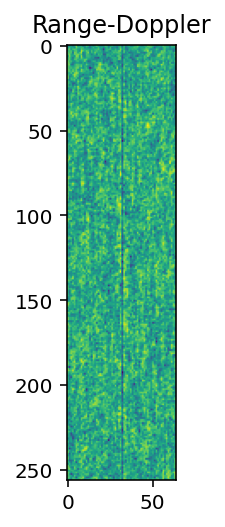

In [11]:
import mmwave.dsp as dsp
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000

numADCSamples = ADC_PARAMS['samples']
numTxAntennas = ADC_PARAMS['tx']
numRxAntennas = ADC_PARAMS['rx']
numLoopsPerFrame = ADC_PARAMS['chirps']
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame

numRangeBins = numADCSamples
numDopplerBins = numLoopsPerFrame

range_resolution, bandwidth = dsp.range_resolution(numADCSamples)
doppler_resolution = dsp.doppler_resolution(bandwidth)

adc_data = np.fromfile('raw_data_2022-07-29-00-47-44.bin', dtype=np.uint16)

BYTES_IN_FRAME = (numLoopsPerFrame * numTxAntennas * numRxAntennas *
            2 * numADCSamples * 2)//2
dataBytes = adc_data.shape[0]
numFrames = int(np.ceil(dataBytes/BYTES_IN_FRAME))
restBytes=numFrames*BYTES_IN_FRAME-dataBytes
fillZeros = np.zeros(restBytes)
adc_data = np.append(adc_data,fillZeros)

numFrames = adc_data.shape[0]//BYTES_IN_FRAME
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples, Qfirst=True)
print("Data Loaded!")

# (2) Range Processing
from mmwave.dsp.utils import Window

radar_cube = dsp.range_processing(adc_data[frame_index], window_type_1d=Window.BLACKMAN)
assert radar_cube.shape == (
numChirpsPerFrame, numRxAntennas, numADCSamples), "[ERROR] Radar cube is not the correct shape!"

# (3) Doppler Processing 
det_matrix, aoa_input = dsp.doppler_processing(radar_cube, num_tx_antennas=numTxAntennas, clutter_removal_enabled=True, window_type_2d=Window.HAMMING)

# --- Show output
det_matrix_vis = np.fft.fftshift(det_matrix, axes=1)
plt.imshow(det_matrix_vis / det_matrix_vis.max())
plt.title("Range-Doppler")
plt.show()

# 解析UART接收的片内DSP处理过的点云、doppler等数据

## 载入相关库

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 载入保存的串口解析数据

In [11]:
DSP_Processed_data=np.load('DSP_Processed_data.npy', allow_pickle=True)
DSP_Processed_data[frame_index].keys() # 查看字典所有键值

dict_keys(['parser_result', 'headerStartIndex', 'platform', 'frameNumber', 'timeCpuCycles', 'totalPacketNumBytes', 'numDetObj', 'numTlv', 'subFrameNumber', 'detectedX_array', 'detectedY_array', 'detectedZ_array', 'detectedV_array', 'detectedRange_array', 'detectedAzimuth_array', 'detectedElevAngle_array', 'detectedSNR_array', 'detectedNoise_array', 'rangeProfile_array', 'noiseFloor_array', 'azimuthHeatMap_array', 'rangeDoppler_array', 'stats_array', 'temperature_stats_array', 'config_params'])

## 显示cfg文件设置的数据

In [12]:
DSP_Processed_data[frame_index]['config_params']

{'numDopplerBins': 64,
 'numRangeBins': 128,
 'rangeResolutionMeters': 0.08720424107142857,
 'rangeIdxToMeters': 0.08720424107142857,
 'dopplerResolutionMps': 0.0313061172587235,
 'maxRange': 10.045928571428572,
 'maxVelocity': 1.001795752279152,
 'sleepTime': 0.5,
 'num_rx_ant': 4,
 'num_tx_ant': 2}

## 显示片内处理时间
可用来判断是否需要调整帧率

In [13]:
DSP_Processed_data[frame_index]['stats_array']

[{'interFrameProcessingTime': 1918,
  'transmitOutputTime': 238797,
  'interFrameProcessingMargin': 435858,
  'interChirpProcessingMargin': 0,
  'activeFrameCPULoad': 0,
  'interFrameCPULoad': 0}]

## 显示各天线温度

In [14]:
DSP_Processed_data[frame_index]['temperature_stats_array']

[{'tempReportValid': 0,
  'time': 2761,
  'tmpRx0Sens': 45,
  'tmpRx1Sens': 46,
  'tmpRx2Sens': 46,
  'tmpRx3Sens': 46,
  'tmpTx0Sens': 47,
  'tmpTx1Sens': 47,
  'tmpTx2Sens': 49,
  'tmpPmSens': 49,
  'tmpDig0Sens': 45,
  'tmpDig1Sens': 44}]

## 显示数据包信息

In [15]:
print("解析结果：        \t",DSP_Processed_data[frame_index]['parser_result'],"(0表示成功)")
print("包头起始位置：    \t",DSP_Processed_data[frame_index]['headerStartIndex'],"(bytes)")
print("雷达平台型号：    \t",DSP_Processed_data[frame_index]['platform'])
print("当前帧序号：      \t",DSP_Processed_data[frame_index]['frameNumber'])
print("子帧序号：        \t",DSP_Processed_data[frame_index]['subFrameNumber'])
print("当前CPU时钟周期： \t",DSP_Processed_data[frame_index]['timeCpuCycles'])
print("当前帧数据包大小：\t",DSP_Processed_data[frame_index]['totalPacketNumBytes'],"(bytes)")
print("点云点数：        \t",DSP_Processed_data[frame_index]['numDetObj'])
print("TLV结构块数：     \t",DSP_Processed_data[frame_index]['numTlv'])


解析结果：        	 0 (0表示成功)
包头起始位置：    	 0 (bytes)
雷达平台型号：    	 b'000a1843'
当前帧序号：      	 3
子帧序号：        	 0
当前CPU时钟周期： 	 552762675
当前帧数据包大小：	 21280 (bytes)
点云点数：        	 6
TLV结构块数：     	 8


## 显示点云数据
其中距离、角度均根据x、y、z计算而来

In [16]:
print("              |------------------直接接收------------------|    |----------------计算得到--------------|  |---------直接接收--------|")
print("              x(m)         y(m)         z(m)        v(m/s)      range(m)   azimuth(deg)  elevAngle(deg)  snr(0.1dB)    noise(0.1dB)")
for obj in range(DSP_Processed_data[frame_index]['numDetObj']):
    print("obj%3d: %12f %12f %12f %12f %12f %12f %12d %12d %12d" % (obj, 
                DSP_Processed_data[frame_index]['detectedX_array'][obj], 
                DSP_Processed_data[frame_index]['detectedY_array'][obj], 
                DSP_Processed_data[frame_index]['detectedZ_array'][obj], 
                DSP_Processed_data[frame_index]['detectedV_array'][obj], 
                DSP_Processed_data[frame_index]['detectedRange_array'][obj], 
                DSP_Processed_data[frame_index]['detectedAzimuth_array'][obj], 
                DSP_Processed_data[frame_index]['detectedElevAngle_array'][obj], 
                DSP_Processed_data[frame_index]['detectedSNR_array'][obj], 
                DSP_Processed_data[frame_index]['detectedNoise_array'][obj]))

              |------------------直接接收------------------|    |----------------计算得到--------------|  |---------直接接收--------|
              x(m)         y(m)         z(m)        v(m/s)      range(m)   azimuth(deg)  elevAngle(deg)  snr(0.1dB)    noise(0.1dB)
obj  0:     0.057263     0.065839     0.000000     0.000000     0.087257    41.014503            0          278          861
obj  1:    -0.084531     0.021643     0.000000     0.000000     0.087257   -75.638491            0          278          861
obj  2:    -0.098165     1.567562     0.000000     0.000000     1.570633    -3.583322            0          378          861
obj  3:     1.559726     1.647488     0.000000     0.000000     2.268692    43.432538            0          164          856
obj  4:     0.818038     4.285491     0.000000     0.000000     4.362869    10.806923            0          218          727
obj  5:    -0.425380     6.792770     0.000000     0.000000     6.806076    -3.583321            0          184          

## 计算距离标签及多普勒速度标签
用于将rangeBin及dopplerBin转化成距离单位m、速度单位m/s方便绘图

In [17]:
rangeBinTicks=np.arange(DSP_Processed_data[frame_index]['config_params']['numRangeBins'])
rangeBinLables=np.round(rangeBinTicks*DSP_Processed_data[frame_index]['config_params']['rangeIdxToMeters'],2)

dopplerBinTicks=np.arange(DSP_Processed_data[frame_index]['config_params']['numDopplerBins'])
dopplerBinLables=np.round(np.arange(-DSP_Processed_data[frame_index]['config_params']["numDopplerBins"]/2 , 
                                     DSP_Processed_data[frame_index]['config_params']["numDopplerBins"]/2
                                   )*DSP_Processed_data[frame_index]['config_params']["dopplerResolutionMps"],2)

## 显示range profile及noise floor profile
1. range profile是doppler bin处于速度最小值（第0个多普勒（静止物体））处的range bin采样点序列，这些点代表以Q9格式表示的接收天线的log2幅度之和。
2. noise floor profile是doppler bin处于速度最大值时的range bin幅值，一般来说，对于静止场景，在最大速度下不会有物体或杂波，因此在这种速度下的距离分布代表接收器的本底噪声。本底噪声是信号中的背景噪声水平，或系统引入的噪声水平，低于该水平，捕获的信号无法与噪声分离。

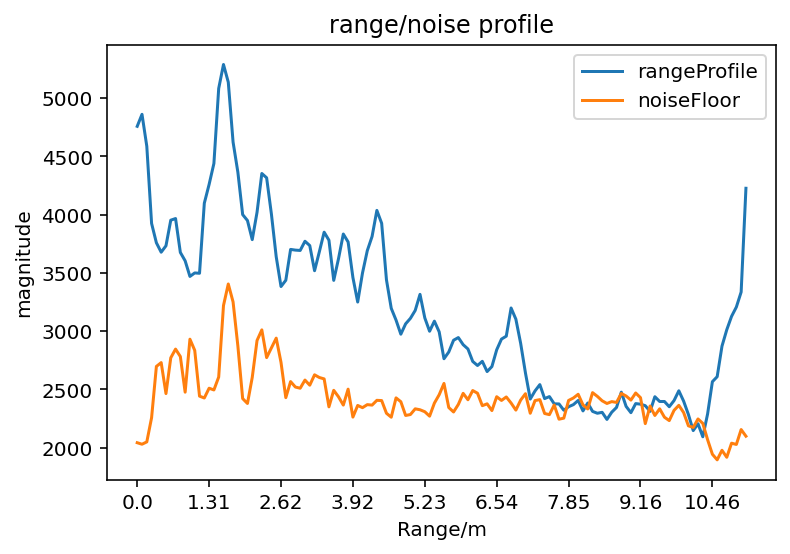

In [18]:
plt.plot(DSP_Processed_data[frame_index]['rangeProfile_array'][0], label='rangeProfile')
plt.plot(DSP_Processed_data[frame_index]['noiseFloor_array'][0], label='noiseFloor')
plt.ylabel('magnitude')
plt.xlabel('Range/m')
plt.xticks(rangeBinTicks[::15],rangeBinLables[::15])
plt.title('range/noise profile')
plt.legend()
plt.show()

## 显示多普勒图Doppler Bins

### 方法一
利用plt.imshow绘制图片

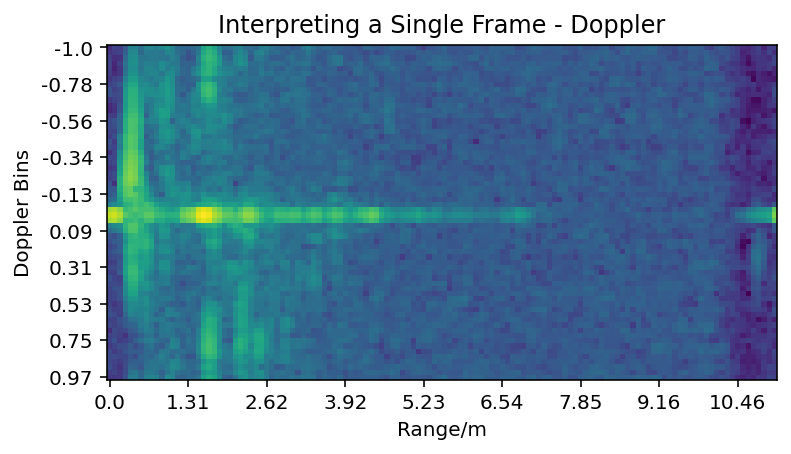

In [19]:
range_doppler=DSP_Processed_data[frame_index]['rangeDoppler_array'][0]
range_doppler = np.fft.fftshift(range_doppler, axes=1)

plt.imshow(np.log(range_doppler.T))
plt.ylabel('Doppler Bins')
plt.xlabel('Range/m')
plt.yticks(dopplerBinTicks[::7],dopplerBinLables[::7])
plt.xticks(rangeBinTicks[::15],rangeBinLables[::15])
plt.title('Interpreting a Single Frame - Doppler')
plt.show()

### 方法二
利用plt.contourf绘制等高线

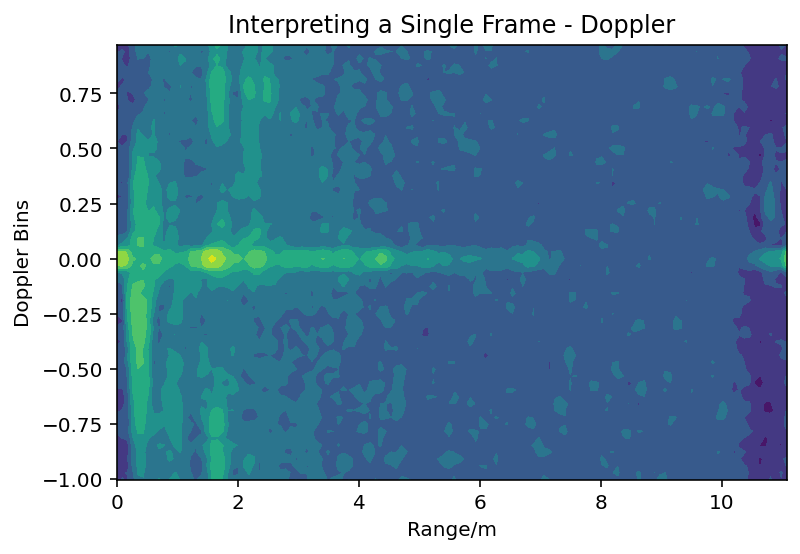

In [20]:
range_doppler=DSP_Processed_data[frame_index]['rangeDoppler_array'][0]
range_doppler = np.fft.fftshift(range_doppler, axes=1)

rangeArray = rangeBinTicks*DSP_Processed_data[frame_index]['config_params']['rangeIdxToMeters']
dopplerArray = np.multiply(np.arange(-DSP_Processed_data[frame_index]['config_params']["numDopplerBins"]/2 , DSP_Processed_data[frame_index]['config_params']["numDopplerBins"]/2), DSP_Processed_data[frame_index]['config_params']["dopplerResolutionMps"])
plt.contourf(rangeArray,dopplerArray,np.log(range_doppler.T))
plt.ylabel('Doppler Bins')
plt.xlabel('Range/m')
plt.title('Interpreting a Single Frame - Doppler')
plt.show()

## 显示方位角图Azimuth (Angle) Bins

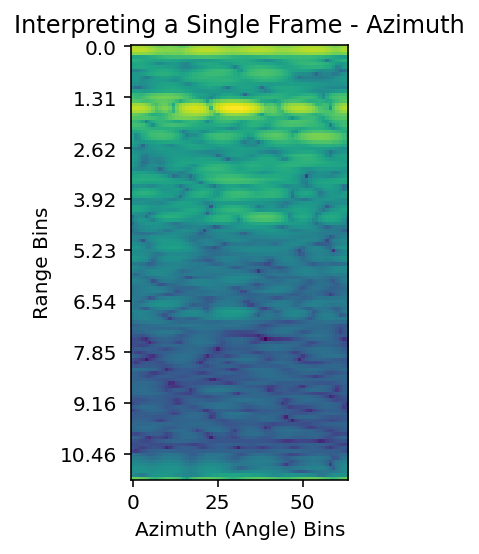

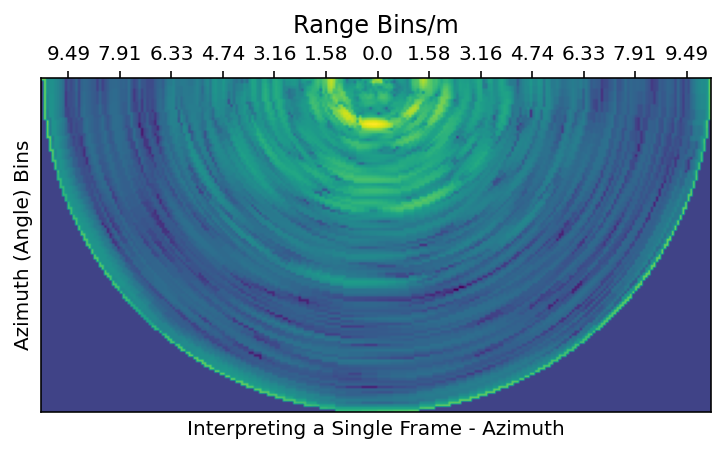

In [21]:
range_doppler=DSP_Processed_data[frame_index]['azimuthHeatMap_array'][0]
num_angle_bins = 64
padding = ((0,0), (0,num_angle_bins-range_doppler.shape[1]))
range_azimuth = np.pad(range_doppler, padding, mode='constant')
range_azimuth = np.fft.fft(range_azimuth, axis=1)
range_azimuth = np.fft.fftshift(range_azimuth, axes=1)
# 绘制平面图
range_azimuth_img=np.log(np.abs(range_azimuth))
plt.imshow(range_azimuth_img)
plt.xlabel('Azimuth (Angle) Bins')
plt.ylabel('Range Bins')
plt.yticks(rangeBinTicks[::15],rangeBinLables[::15])
plt.title('Interpreting a Single Frame - Azimuth')
plt.show()

#绘制扇扫图
im_fan=fanScan(range_azimuth_img,r0=0,angle=180,k=12,top=True)
plt.imshow(im_fan)
#坐标标签上移
ax = plt.gca()
ax.xaxis.set_ticks_position('top')
#标注距离
lableNum=7 #单侧标签个数
range_xlable=np.arange(0,rangeBinLables[-1],rangeBinLables[-1]/lableNum)
range_xlable=np.round(np.concatenate((range_xlable[:0:-1], range_xlable)),2)
range_xticks_l=np.arange((DSP_Processed_data[frame_index]['config_params']['numRangeBins']*2-1)/2,0,-(DSP_Processed_data[frame_index]['config_params']['numRangeBins']*2-1)/(2*lableNum-1))
range_xticks_h=np.arange((DSP_Processed_data[frame_index]['config_params']['numRangeBins']*2-1)/2,DSP_Processed_data[frame_index]['config_params']['numRangeBins']*2-1,(DSP_Processed_data[frame_index]['config_params']['numRangeBins']*2-1)/(2*lableNum-1))
range_xticks=np.concatenate((range_xticks_l[:0:-1], range_xticks_h))
plt.xticks(range_xticks,range_xlable)
plt.yticks([])  # 去掉y轴
plt.title('Range Bins/m')
plt.ylabel('Azimuth (Angle) Bins')
plt.xlabel('Interpreting a Single Frame - Azimuth')
plt.show()